# SCADA Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import statsmodels.tsa.stattools as sts
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import xgboost as xgb
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go

from math import sqrt
import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

In [2]:
data = pd.read_excel('data/8 Hrs 3 Proc Normal.xlsx', sheet_name = 'Sheet1')

In [3]:
data_with_attacks = pd.read_excel('data/8 Hrs 3 Proc Normal+Attack.xlsx', 
                                  sheet_name = 'Combined Data')

## Cleaning Data

In [4]:
data.columns = ['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'Normal/Attack']

In [5]:
data_with_attacks.columns = ['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301',
       'MV302', 'MV303', 'MV304', 'P301', 'P302', 'Normal/Attack']

In [6]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [7]:
data_with_attacks['Timestamp'] = pd.to_datetime(data_with_attacks['Timestamp'])

In [8]:
data.head(2)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,Normal/Attack
0,2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,20.79839,2.235275,327.4401,1,2,1,1,2,1,Normal
1,2015-12-22 16:00:01,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,20.79839,2.234507,327.4401,1,2,1,1,2,1,Normal


In [9]:
data_with_attacks.head(2)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,Normal/Attack
0,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,19.74838,2.206835,956.1651,1,2,1,1,1,2,Normal
1,2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,19.74838,2.208244,956.1651,1,2,1,1,1,2,Normal


In [10]:
data_with_attacks.replace(to_replace = 'Normal', value = 0, inplace = True)
data_with_attacks.replace(to_replace = 'Attack', value = 1, inplace = True)

## Testing for Stationarity

The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.

The hypotheses for the test:
* The null hypothesis for this test is that there is a unit root.
* The alternate hypothesis differs slightly according to which equation you’re using. The basic alternate is that the time series is stationary (or trend-stationary).

In [11]:
l = []
alpha = 0.05

for i in range(1,data.shape[1]-1):
    test  = sts.adfuller(data.iloc[:,i].diff(1).dropna())    
    if(test[1] < alpha):
        is_stationary = True
    else:
        is_stationary = False
        
    row = {}
    row['colname'] = data.columns[i]
    row['is_stationary'] = is_stationary
    l.append(row)

stationarity_tests = pd.DataFrame(l)

In [12]:
stationarity_tests

,colname,is_stationary
0,FIT101,True
1,LIT101,True
2,MV101,True
3,P101,True
4,P102,False
5,AIT201,True
6,AIT202,True
7,AIT203,True
8,FIT201,True
9,MV201,True


## IQR Anomaly Detection

### Calculating range for outliers

* The IQR is the length of the box in your box-and-whisker plot. An outlier is any value that lies more than one and a half times the length of the box from either end of the box.

In [13]:
# function to calculate lower bound
def lower_bound(column):
    return column.min() - 1.5*(column.quantile(0.75) - column.quantile(0.25))

# function to calculate upper bound
def upper_bound(column):
    return column.max() + 1.5*(column.quantile(0.75) - column.quantile(0.25))

In [14]:
l = []

# find lower and upper bound of every column except first and the last
for i in range(1, data.shape[1] - 1):
    row = {}
    row['column'] = data.columns[i]
    row['upper_bound'] = data.iloc[:,i].agg(upper_bound)
    row['lower_bound'] = data.iloc[:,i].agg(lower_bound)
    l.append(row)
    
iqr_df = pd.DataFrame(l)

In [15]:
iqr_df.head(5)

,column,upper_bound,lower_bound
0,FIT101,2.955513,-0.264228
1,LIT101,1486.518400,-365.894700
2,MV101,2.000000,0.000000
3,P101,2.000000,1.000000
4,P102,1.000000,1.000000


In [16]:
iqr_df.to_csv('output/iqr_test.csv', index = False)

### Testing outliers on data with attacks

In [19]:
# function to check if outlier lies between lower and upper bounds
def iqr_outlier_detection(x):
    x = pd.DataFrame(x).reset_index()
    x.columns = ['column', 'value']
    iqr_x = pd.merge(x, iqr_df, on = 'column', how = 'right')
    iqr_x['Test'] = (iqr_x['value'] > iqr_x['upper_bound']) | (iqr_x['value'] < iqr_x['lower_bound'])
    return 1 if iqr_x['Test'].any() else 0

In [20]:
data_with_attacks['iqr_result'] = data_with_attacks.apply(lambda x: iqr_outlier_detection(x), axis = 1)

### Evaluating IQR Model

In [21]:
confusion_matrix(y_true = data_with_attacks['Normal/Attack'], y_pred = data_with_attacks['iqr_result'])

array([[24448,    32],
       [ 2728,  1591]])

In [22]:
accuracy_score(y_true = data_with_attacks['Normal/Attack'], y_pred = data_with_attacks['iqr_result']) * 100

90.41633390048266

In [23]:
print(classification_report(y_true = data_with_attacks['Normal/Attack'], y_pred = data_with_attacks['iqr_result']))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     24480
           1       0.98      0.37      0.54      4319

    accuracy                           0.90     28799
   macro avg       0.94      0.68      0.74     28799
weighted avg       0.91      0.90      0.88     28799



In [24]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true = data_with_attacks['Normal/Attack'], 
                                  y_score = data_with_attacks['iqr_result'])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true = data_with_attacks['Normal/Attack'].ravel(), 
                                          y_score = data_with_attacks['iqr_result'].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

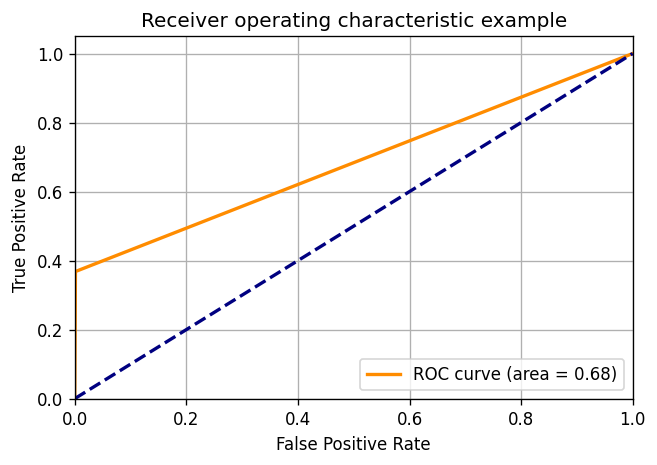

In [25]:
plt.figure(dpi = 120)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Preparing Data for Regression Algorithms

In [26]:
train_test = data_with_attacks.drop('Timestamp', axis = 1)

In [27]:
train, test = train_test_split(train_test, test_size=0.25, stratify = train_test['Normal/Attack'], random_state=1234)

In [28]:
training, validation = train_test_split(train, test_size=0.25, stratify=train['Normal/Attack'], random_state=1234)

In [29]:
x_train = training.drop('Normal/Attack', axis = 1)
y_train = training['Normal/Attack']
x_val = validation.drop('Normal/Attack', axis = 1)
y_val = validation['Normal/Attack']

In [30]:
X_test = test.drop('Normal/Attack', axis = 1)
Y_test = test['Normal/Attack']

### CatBoostRegressor

In [31]:
# initializing model with parameters
cbr = CatBoostRegressor(max_depth=4, 
                        learning_rate=0.06900,
                        loss_function='RMSE',
                        n_estimators=500,
                        one_hot_max_size=2,
                        eval_metric='AUC',
                        boosting_type='Ordered',
                        random_seed=2405, 
                        use_best_model=True,
                        silent=True,
                        random_strength=1.0944250924022183,
                        reg_lambda=1.2762795426592872)

In [32]:
cbr.fit(x_train, y_train, eval_set=(x_val, y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Evaluation Performance of CatBoostRegressor

In [33]:
prediction = cbr.predict(X_test)

In [34]:
sqrt(mean_squared_error(Y_test, prediction))

0.03271018019231614

In [35]:
class_prediction = prediction.copy()

class_prediction[class_prediction >= 0.5] = 1
class_prediction[class_prediction < 0.5] = 0

In [36]:
confusion_matrix(y_true = Y_test, y_pred = class_prediction)

array([[6120,    0],
       [   1, 1079]])

In [37]:
accuracy_score(y_true = Y_test, y_pred = class_prediction) * 100

99.98611111111111

In [38]:
print(classification_report(y_true = Y_test, y_pred = class_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6120
           1       1.00      1.00      1.00      1080

    accuracy                           1.00      7200
   macro avg       1.00      1.00      1.00      7200
weighted avg       1.00      1.00      1.00      7200



In [39]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true = Y_test, 
                                  y_score = class_prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true = Y_test.ravel(), 
                                          y_score = class_prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

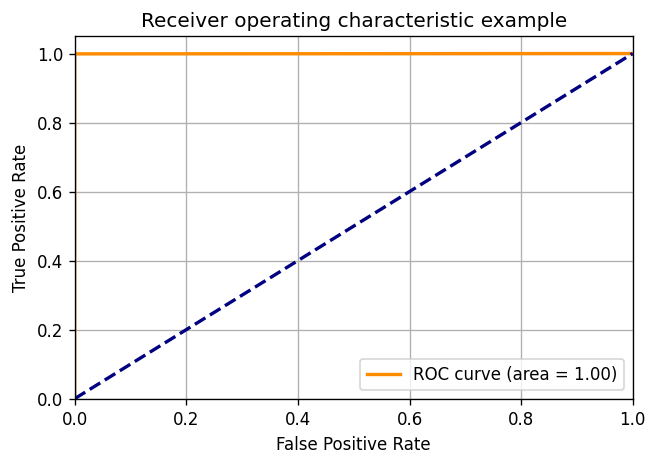

In [40]:
plt.figure(dpi = 120)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### XGBoost

In [41]:
xgc = xgb.XGBClassifier(
        n_estimators=10000,
        objective='binary:logistic',
        n_jobs=-1
    )

In [42]:
dtrain = xgb.DMatrix(x_train,label=y_train)
dtest = xgb.DMatrix(x_val)

In [43]:
#setting parameters for XGBoost
parameters={'max_depth':4, 
            'min_child_weight': 18, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'learning_rate':0.0638840541928953,
            'subsample': 0.7642763922160356,
            'colsample_bytree': 0.5695032486938503,
            'reg_lambda': 98.64817753125035,}

In [44]:
xg = xgb.train(parameters,dtrain)

#### Evaluating Performance of XBGoost

In [45]:
ypred = xg.predict(dtest)

In [46]:
# performance on validation set
sqrt(mean_squared_error(y_val, ypred))

0.34309267537412275

In [47]:
# performance on test set
dtest_final = xgb.DMatrix(X_test)

In [48]:
pred = xg.predict(dtest_final)

In [49]:
sqrt(mean_squared_error(Y_test, pred))

0.34187571532104605

In [50]:
class_prediction = pred.copy()

class_prediction[class_prediction >= 0.5] = 1
class_prediction[class_prediction < 0.5] = 0

In [51]:
confusion_matrix(y_true = Y_test, y_pred = class_prediction)

array([[6112,    8],
       [ 461,  619]])

In [52]:
accuracy_score(y_true = Y_test, y_pred = class_prediction) * 100

93.48611111111111

In [53]:
print(classification_report(y_true = Y_test, y_pred = class_prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6120
           1       0.99      0.57      0.73      1080

    accuracy                           0.93      7200
   macro avg       0.96      0.79      0.84      7200
weighted avg       0.94      0.93      0.93      7200



In [54]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true = Y_test, 
                                  y_score = class_prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true = Y_test.ravel(), 
                                          y_score = class_prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

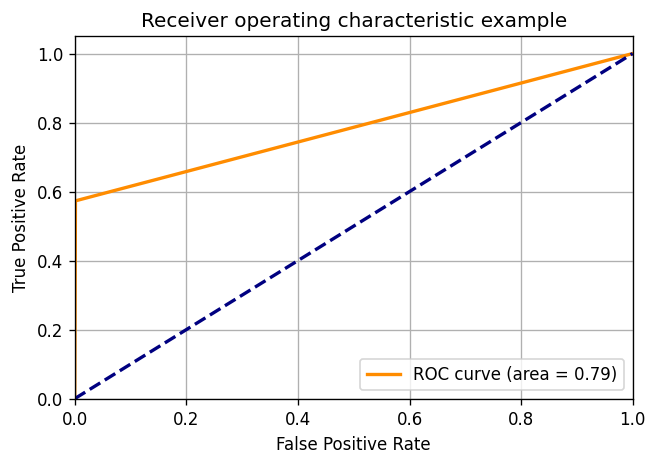

In [55]:
plt.figure(dpi = 120)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Isolation Forests

In [56]:
#specify the column names to be modelled

to_model_columns=data_with_attacks.columns[1:-2]
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(data_with_attacks[to_model_columns])

pred = clf.predict(data_with_attacks[to_model_columns])
data_with_attacks['isolation_forest_anomaly']=pred

outliers=data_with_attacks.loc[data_with_attacks['isolation_forest_anomaly']==-1]
outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(data_with_attacks['isolation_forest_anomaly'].value_counts())

 1    25343
-1     3456
Name: isolation_forest_anomaly, dtype: int64


### Plotting outliers and inliers using PCA

Normalize and fit the metrics to a PCA to reduce the number of dimensions and then plot them in 3D highlighting the anomalies.

In [57]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(data_with_attacks[to_model_columns])
X_reduce = pca.fit_transform(X)

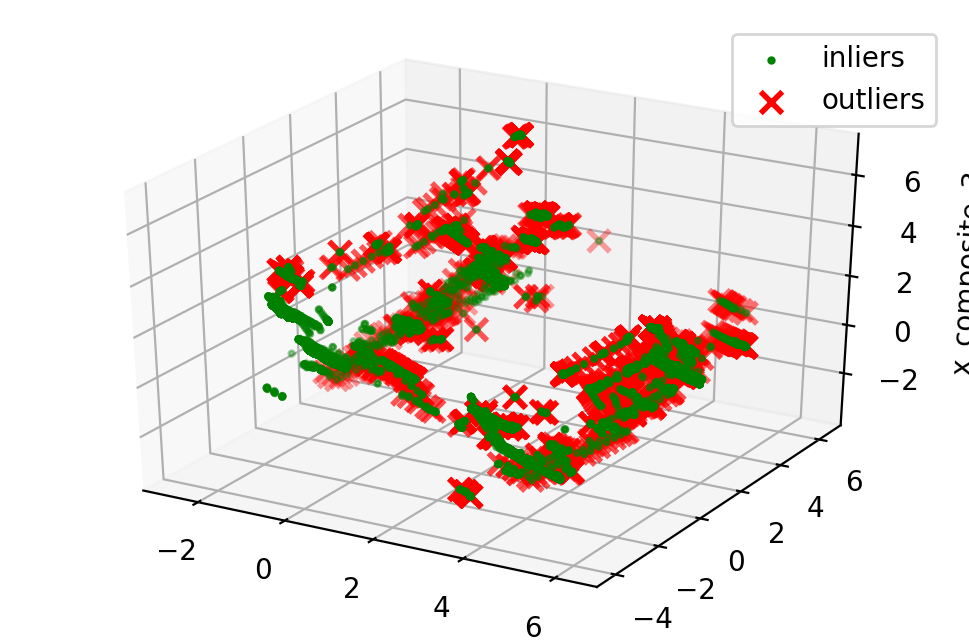

In [58]:
fig = plt.figure(dpi = 200)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [59]:
data_with_attacks['isolation_forest_result'] = data_with_attacks\
.isolation_forest_anomaly.apply(lambda x: 1 if x == -1 else 0)

### Evaluating Performance of Isolation Forest

In [60]:
confusion_matrix(y_true = data_with_attacks['Normal/Attack'], y_pred = data_with_attacks['isolation_forest_result'])

array([[22423,  2057],
       [ 2920,  1399]])

In [61]:
accuracy_score(y_true = data_with_attacks['Normal/Attack'], 
               y_pred = data_with_attacks['isolation_forest_result'])* 100

82.71814993576166

In [62]:
print(classification_report(y_true = data_with_attacks['Normal/Attack'], 
                            y_pred = data_with_attacks['isolation_forest_result']))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     24480
           1       0.40      0.32      0.36      4319

    accuracy                           0.83     28799
   macro avg       0.64      0.62      0.63     28799
weighted avg       0.81      0.83      0.82     28799



In [63]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true = data_with_attacks['Normal/Attack'], 
                                  y_score = data_with_attacks['isolation_forest_result'])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true = data_with_attacks['Normal/Attack'].ravel(), 
                                          y_score = data_with_attacks['isolation_forest_result'].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

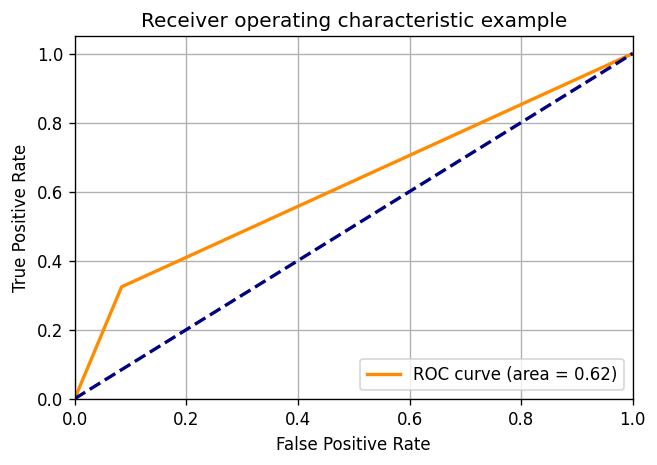

In [64]:
plt.figure(dpi = 120)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()

* Now we have figured the anomalous behavior at a use case level.
* But to be actionable on the anomaly its important to identify and provide information on which metrics are anomalous in it individually.
* The anomalies identified by the algorithm should make sense when viewed visually(sudden dip/peaks) by the business user to act upon it. 
* So creating a good visualization is equally important in this process.

### Individual Metrics

* This function creates actuals plot on a time series with anomaly points highlighted on it. Also a table which provides actual data, the change and conditional formatting based on anomalies.
* A helper function to find percentage change,classify anomaly based on severity.
* The predict function classifies the data as anomalies based on the results from decision function on crossing a threshold.
* Say if the business needs to find the next level of anomalies which might have an impact, this could be used to identify those points.
* The top 12 quantiles are identified anomalies(high severity), based on decision function here we identify the 12–24 quantile points and classify them as low severity anomalies.

In [65]:
def plot_anomaly(df, metric_name):
    dates = df.Timestamp
    # identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    # A dictionary for conditional format table based on anomaly
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "red"}

    # Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(height=20,
                    values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],
                            ],
                    font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                    fill=dict(color='#d562be')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['Timestamp', 'actuals', 'percentage_change']],
                   line=dict(color='#506784'),
                   align=['center'] * 5,
                   font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                   # format = [None] + [",.4f"] + [',.4f'],
                   # suffix=[None] * 4,
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[test_df['anomaly_class'].map(color_map)],  # map based on anomaly level from dictionary
                             )
                   ))
    # Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['actuals'],
                         xaxis='x1', yaxis='y1',
                         mode='line',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))
    # Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1],
                                 anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    plot(fig, filename='plots/{0}.html'.format(metric_name), auto_open=False)


In [66]:
def classify_anomalies(df, metric_name):
    df['metric_name'] = metric_name
    df = df.sort_values(by='Timestamp', ascending=False)
    # Shift actuals by one timestamp to find the percentage chage between current and previous data point
    df['shift'] = df['actuals'].shift(-1)
    df['percentage_change'] = (
        (df['actuals'] - df['shift']) / df['actuals']) * 100
    # Categorise anomalies as 0-no anomaly, 1- low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (
        df['score'] <= medium_percentile)] = 1
    return df

* Plots for each individual metrics saved as HTML file in plots folder

In [67]:
for i in range(1, len(data_with_attacks.columns)-4):
    clf.fit(data_with_attacks.iloc[:, i:i+1])
    pred = clf.predict(data_with_attacks.iloc[:, i:i+1])
    test_df = pd.DataFrame()
    test_df['Timestamp'] = data_with_attacks['Timestamp']
    # Find decision function to find the score and classify anomalies
    test_df['score'] = clf.decision_function(data_with_attacks.iloc[:, i:i+1])
    test_df['actuals'] = data_with_attacks.iloc[:, i:i+1]
    test_df['anomaly'] = pred
    # Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers = test_df.loc[test_df['anomaly'] == -1]
    outlier_index = list(outliers.index)
    test_df = classify_anomalies(test_df, data_with_attacks.columns[i])
    plot_anomaly(test_df, data_with_attacks.columns[i])

## References

1. https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
2. https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html